In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3a
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0, 0]
ng_refs = [2, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(10, 250), (600, 250)]
tsfc = 294
vmax = 620
vmin = 540
w_diffuse = [(1.9, 1.7), (1.4, 1.4, 1.4, 1.55, 1.6, 1.66)]
wgt = [(0.7, 0.7), (0.7, 0.5, 0.5, 0.5, 0.5, 0.5)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

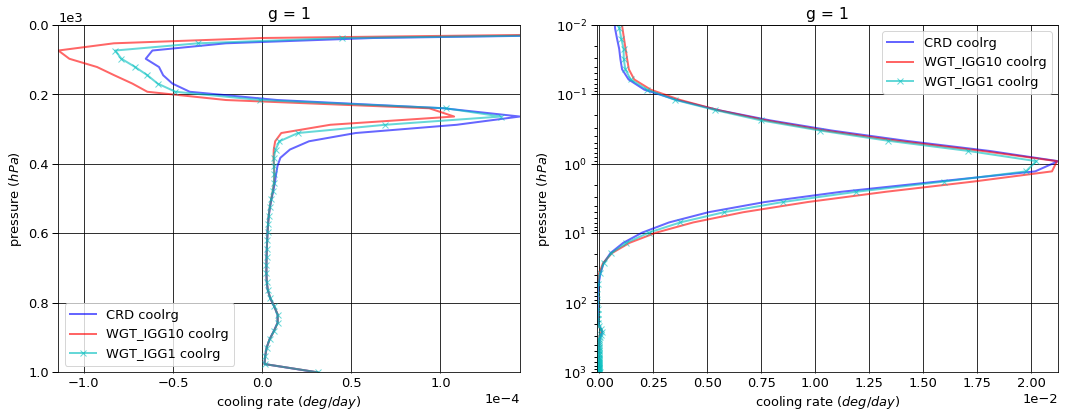

# Figure: cooling rate g-group 2

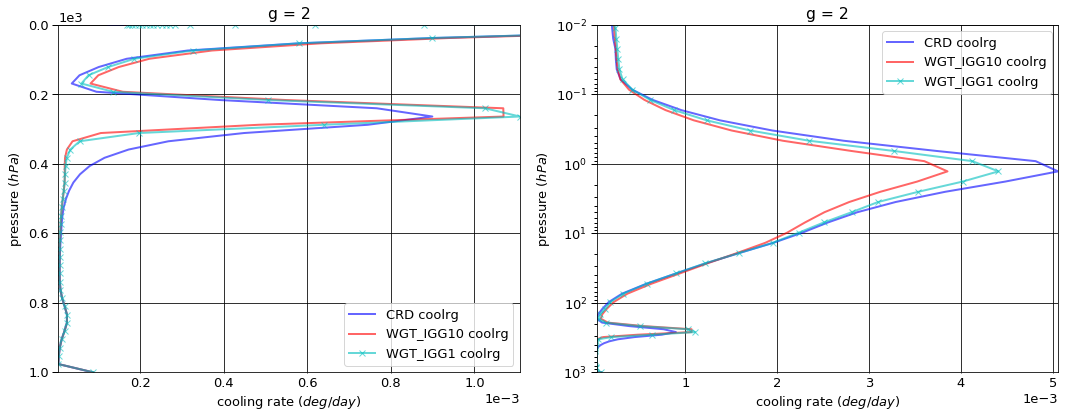

# Figure: cooling rate g-group 3

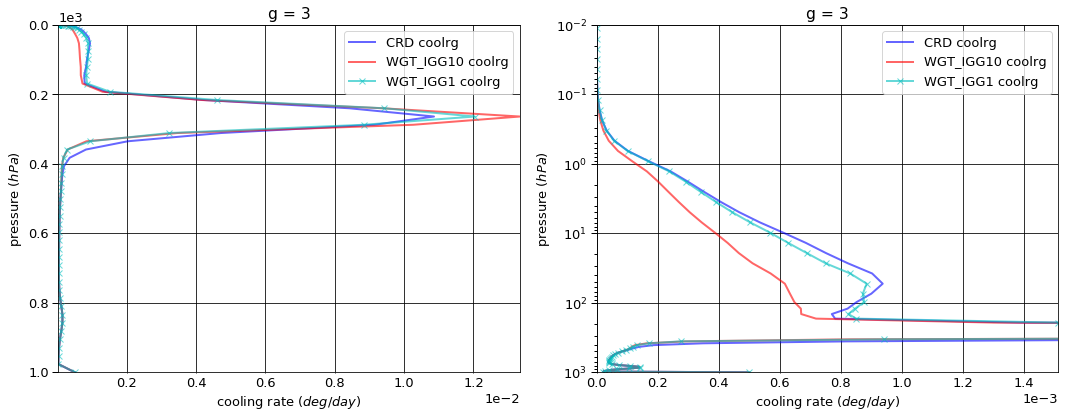

# Figure: cooling rate g-group 4

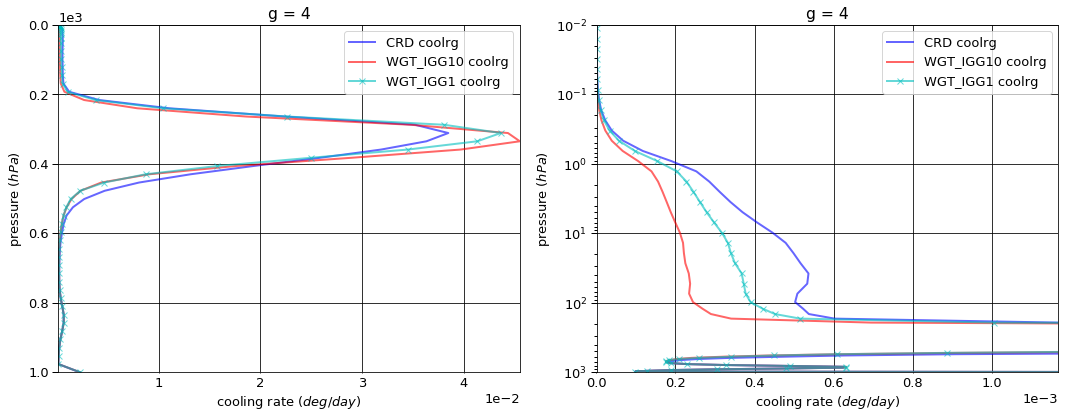

# Figure: cooling rate g-group 5

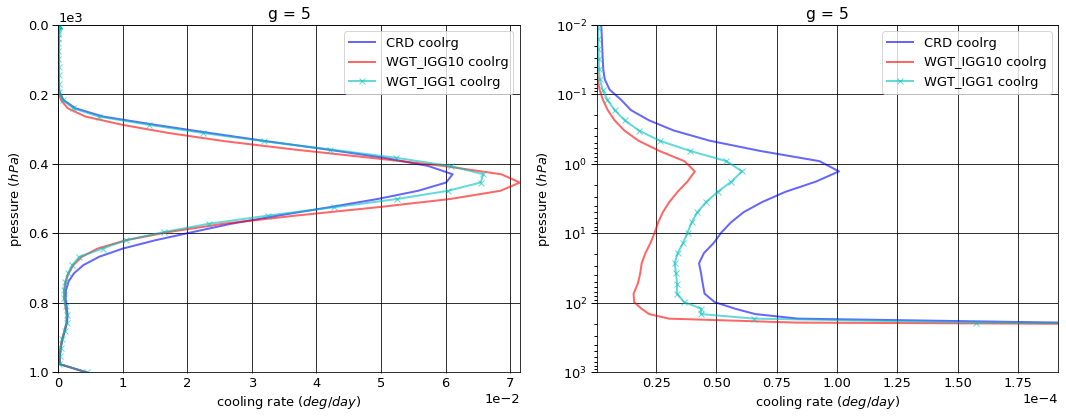

# Figure: cooling rate g-group 6

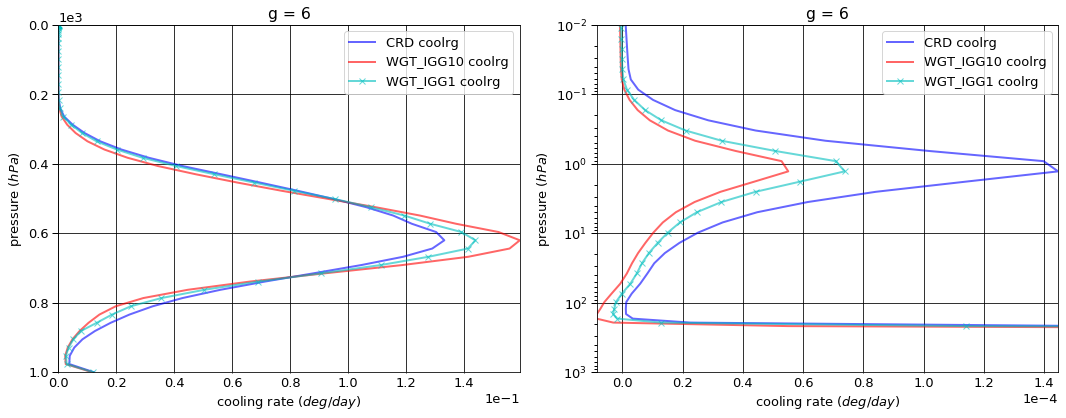

# Figure: cooling rate g-group 7

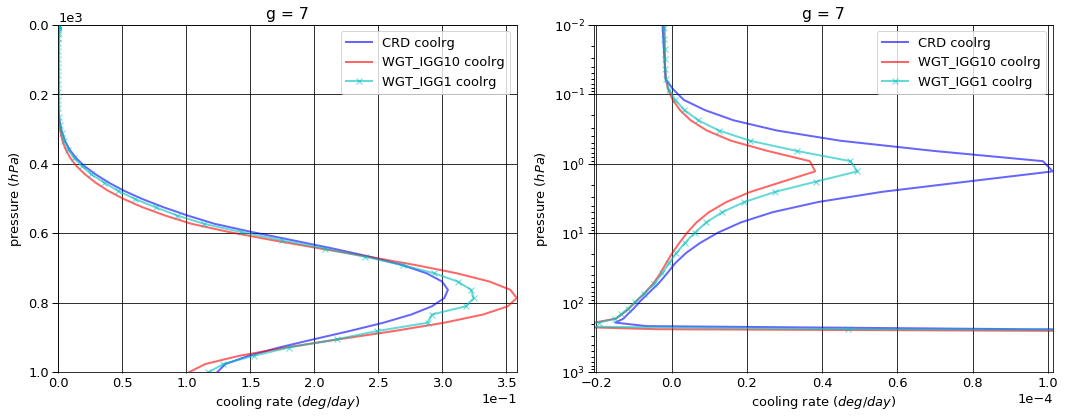

# Figure: cooling rate g-group 8

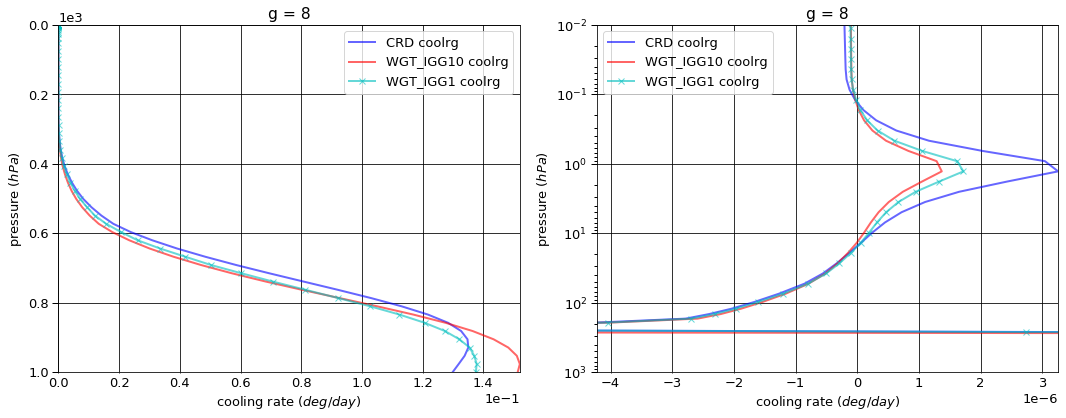

# Figure: cooling rate g-group total

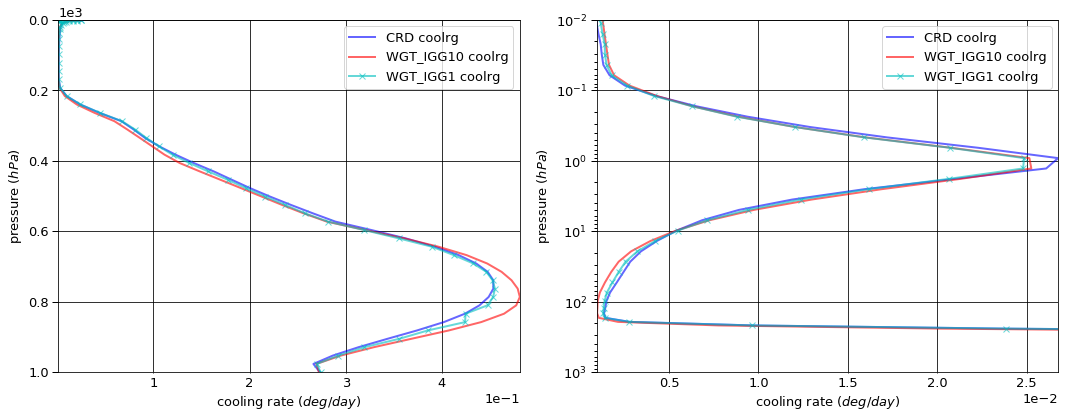

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.010980   0.000000  -0.010980
  1013.0   76     -0.020391   0.020306  -0.000085
2 0.0      1      -0.024774   0.000000  -0.024774
  1013.0   76     -0.057081   0.056843  -0.000238
3 0.0      1      -0.143566   0.000000  -0.143566
  1013.0   76     -0.327646   0.326282  -0.001364
4 0.0      1      -0.763469   0.000000  -0.763469
  1013.0   76     -1.467592   1.461475  -0.006117
5 0.0      1      -1.797997   0.000000  -1.797997
  1013.0   76     -2.871968   2.859981  -0.011988
6 0.0      1      -5.025466   0.000000  -5.025466
  1013.0   76     -6.781431   6.743210  -0.038221
7 0.0      1     -13.979436   0.000000 -13.979436
  1013.0   76    -16.397272  15.428746  -0.968526
8 0.0      1      -7.724982   0.000000  -7.724982
  1013.0   76     -8.312027   5.592179  -2.719848


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.011243   0.000000  -0.011243
  1013.0   76     -0.020468   0.020382  -0.000086
2 0.0      1      -0.023544   0.000000  -0.023544
  1013.0   76     -0.057313   0.057072  -0.000241
3 0.0      1      -0.142633   0.000000  -0.142633
  1013.0   76     -0.329290   0.327906  -0.001384
4 0.0      1      -0.763765   0.000000  -0.763765
  1013.0   76     -1.473931   1.467737  -0.006193
5 0.0      1      -1.814421   0.000000  -1.814421
  1013.0   76     -2.886777   2.874647  -0.012130
6 0.0      1      -5.052627   0.000000  -5.052627
  1013.0   76     -6.817414   6.783494  -0.033920
7 0.0      1     -14.070101   0.000000 -14.070101
  1013.0   76    -16.433299  15.919224  -0.514074
8 0.0      1      -7.718605   0.000000  -7.718605
  1013.0   76     -8.216917   5.388488  -2.828429


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.010982   0.000000  -0.010982
  1013.0   76     -0.020468   0.020382  -0.000086
2 0.0      1      -0.023917   0.000000  -0.023917
  1013.0   76     -0.057313   0.057072  -0.000241
3 0.0      1      -0.140820   0.000000  -0.140820
  1013.0   76     -0.329290   0.327906  -0.001384
4 0.0      1      -0.753417   0.000000  -0.753417
  1013.0   76     -1.473931   1.467737  -0.006193
5 0.0      1      -1.787457   0.000000  -1.787457
  1013.0   76     -2.886777   2.874648  -0.012130
6 0.0      1      -5.025571   0.000000  -5.025571
  1013.0   76     -6.817414   6.782004  -0.035410
7 0.0      1     -14.029172   0.000000 -14.029172
  1013.0   76    -16.433299  15.715273  -0.718026
8 0.0      1      -7.698982   0.000000  -7.698982
  1013.0   76     -8.216917   5.251004  -2.965913


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000263  0.000000 -2.632370e-04
  1013.0   76    -0.000077  0.000076 -9.186270e-07
2 0.0      1      0.001229  0.000000  1.229463e-03
  1013.0   76    -0.000232  0.000229 -2.777090e-06
3 0.0      1      0.000933  0.000000  9.325400e-04
  1013.0   76    -0.001644  0.001624 -1.972060e-05
4 0.0      1     -0.000296  0.000000 -2.959500e-04
  1013.0   76    -0.006338  0.006262 -7.594770e-05
5 0.0      1     -0.016424  0.000000 -1.642420e-02
  1013.0   76    -0.014809  0.014667 -1.425000e-04
6 0.0      1     -0.027161  0.000000 -2.716130e-02
  1013.0   76    -0.035983  0.040284  4.300781e-03
7 0.0      1     -0.090665  0.000000 -9.066500e-02
  1013.0   76    -0.036027  0.490478  4.544520e-01
8 0.0      1      0.006377  0.000000  6.376700e-03
  1013.0   76     0.095110 -0.203691 -1.085811e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000002  0.000000 -2.385000e-06
  1013.0   76    -0.000077  0.000076 -9.186270e-07
2 0.0      1      0.000856  0.000000  8.563650e-04
  1013.0   76    -0.000232  0.000229 -2.777090e-06
3 0.0      1      0.002746  0.000000  2.745630e-03
  1013.0   76    -0.001644  0.001624 -1.972060e-05
4 0.0      1      0.010052  0.000000  1.005221e-02
  1013.0   76    -0.006338  0.006262 -7.594770e-05
5 0.0      1      0.010540  0.000000  1.053980e-02
  1013.0   76    -0.014809  0.014667 -1.421490e-04
6 0.0      1     -0.000105  0.000000 -1.050000e-04
  1013.0   76    -0.035983  0.038794  2.811284e-03
7 0.0      1     -0.049736  0.000000 -4.973600e-02
  1013.0   76    -0.036027  0.286527  2.505005e-01
8 0.0      1      0.026000  0.000000  2.599970e-02
  1013.0   76     0.095110 -0.341175 -2.460650e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      2.117437e-04
  1001.112500 75     3.079506e-05
2 0.000312    1      1.235945e-04
  1001.112500 75     8.615780e-05
3 0.000312    1      4.584487e-09
  1001.112500 75     4.936664e-04
4 0.000312    1      4.128192e-07
  1001.112500 75     2.214120e-03
5 0.000312    1      1.094738e-06
  1001.112500 75     4.338393e-03
6 0.000312    1     -2.942838e-07
  1001.112500 75     1.233327e-02
7 0.000312    1     -3.348809e-06
  1001.112500 75     1.239518e-01
8 0.000312    1     -2.374972e-07
  1001.112500 75     1.298438e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      5.481588e-04
  1001.112500 75     3.112511e-05
2 0.000312    1      1.634184e-04
  1001.112500 75     8.715575e-05
3 0.000312    1      2.726976e-09
  1001.112500 75     5.007519e-04
4 0.000312    1      2.170639e-07
  1001.112500 75     2.241409e-03
5 0.000312    1     -8.632060e-08
  1001.112500 75     4.390173e-03
6 0.000312    1     -1.246806e-06
  1001.112500 75     1.175994e-02
7 0.000312    1     -2.236902e-06
  1001.112500 75     1.019224e-01
8 0.000312    1     -1.157586e-07
  1001.112500 75     1.512990e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      3.892008e-04
  1001.112500 75     3.112511e-05
2 0.000312    1      1.691989e-04
  1001.112500 75     8.715575e-05
3 0.000312    1      4.275652e-09
  1001.112500 75     5.007519e-04
4 0.000312    1      3.974233e-07
  1001.112500 75     2.241409e-03
5 0.000312    1      2.665299e-07
  1001.112500 75     4.389929e-03
6 0.000312    1     -1.107608e-06
  1001.112500 75     1.200060e-02
7 0.000312    1     -2.430930e-06
  1001.112500 75     1.172032e-01
8 0.000312    1     -1.248247e-07
  1001.112500 75     1.375186e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.364151e-04
  1001.112500 75     3.300470e-07
2 0.000312    1      3.982386e-05
  1001.112500 75     9.979500e-07
3 0.000312    1     -1.857511e-09
  1001.112500 75     7.085500e-06
4 0.000312    1     -1.957554e-07
  1001.112500 75     2.728910e-05
5 0.000312    1     -1.181059e-06
  1001.112500 75     5.177950e-05
6 0.000312    1     -9.525226e-07
  1001.112500 75    -5.733350e-04
7 0.000312    1      1.111907e-06
  1001.112500 75    -2.202935e-02
8 0.000312    1      1.217386e-07
  1001.112500 75     2.145521e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.774571e-04
  1001.112500 75     3.300470e-07
2 0.000312    1      4.560436e-05
  1001.112500 75     9.979500e-07
3 0.000312    1     -3.088347e-10
  1001.112500 75     7.085500e-06
4 0.000312    1     -1.539595e-08
  1001.112500 75     2.728910e-05
5 0.000312    1     -8.282083e-07
  1001.112500 75     5.153530e-05
6 0.000312    1     -8.133241e-07
  1001.112500 75    -3.326710e-04
7 0.000312    1      9.178791e-07
  1001.112500 75    -6.748560e-03
8 0.000312    1      1.126725e-07
  1001.112500 75     7.674800e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.470669,0.000000,-29.470669
1013.0,76,-36.235408,32.489021,-3.746387



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.596940,0.000000,-29.596940
1013.0,76,-36.235408,32.838951,-3.396457



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.470318,0.000000,-29.470318
1013.0,76,-36.235408,32.496027,-3.739381



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.262710e-01,0.000000,-0.126271
1013.0,76,-3.110000e-07,0.349929,0.349930



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.503200e-04,0.000000,0.000350
1013.0,76,-3.110000e-07,0.007005,0.007005


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000333
1001.112500,75,0.273292



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000708
1001.112500,75,0.272232



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000555
1001.112500,75,0.273973



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000375
1001.112500,75,-0.001060



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000222
1001.112500,75,0.000681


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000562,0.000565
2,0.001575,0.001582
3,0.009038,0.009088
4,0.040488,0.040677
5,0.079250,0.079667
6,0.187112,0.188142
7,0.452450,0.453515
8,0.229525,0.226765


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.203448e-19
2,1.293116e-20
3,5.751102e-21
4,1.054900e-21
5,1.934958e-22
6,3.549211e-23
7,6.510165e-24
8,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.203448e-19,NaN,0.000562,0.000565,0.000562,0.000565,10.0
2,1.293116e-20,0.107451,0.001575,0.001582,0.002138,0.002147,10.0
3,5.751102e-21,0.444747,0.009038,0.009088,0.011175,0.011234,600.0
4,1.054900e-21,0.183426,0.040488,0.040677,0.051663,0.051911,600.0
5,1.934958e-22,0.183426,0.079250,0.079667,0.130912,0.131578,600.0
6,3.549211e-23,0.183426,0.187112,0.188142,0.318025,0.319720,600.0
7,6.510165e-24,0.183426,0.452450,0.453515,0.770475,0.773235,600.0
8,1.194132e-24,0.183426,0.229525,0.226765,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
